# Demand forecasting with the Temporal Fusion Transformer


In [2]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

In [3]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, random_split

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
import sympy

In [6]:
path = os.getcwd() + '/docs/source/tutorials/project_data/'

## Load data


In [11]:
data = pd.read_csv(path+'230609.csv', index_col=0)
data = data.drop(['time_idx', 'hour','% Iron Concentrate', 'time_range', 'dawn', 'day', 'night'],axis=1)
data

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Silica Concentrate
0,56.90,13.27,2188.172667,496.410433,400.979500,9.656423,1.748558,249.375633,250.348200,249.964633,...,250.029067,250.081467,699.654500,700.733367,700.101233,452.563067,451.789533,449.743700,449.483467,1.43
1,56.90,13.27,2246.475667,495.634233,400.291533,9.667804,1.753257,249.868133,249.040433,250.053367,...,249.317800,249.485167,698.061567,699.669467,699.742700,446.351400,448.587867,453.563433,451.585900,1.43
2,56.90,13.27,2475.248333,502.428933,400.377700,9.715140,1.757305,250.273500,249.759633,250.299933,...,250.343100,250.200900,700.889667,700.782800,697.921467,450.662033,450.802967,451.608367,453.117867,1.43
3,56.90,13.27,2291.417667,501.038067,395.883467,9.758797,1.763687,250.081533,250.211900,250.293367,...,248.608867,249.992500,698.023633,699.016767,701.067967,450.059533,451.693433,450.546067,453.716600,1.43
4,56.90,13.27,2067.281000,489.734600,401.647467,9.746133,1.762028,250.064600,249.117100,250.051367,...,249.632900,250.809800,702.646667,700.614833,699.986133,455.145800,455.001233,446.797833,441.841933,1.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21883,49.75,23.20,4067.137000,454.760300,380.728578,9.670436,1.675748,299.134467,299.967633,299.752200,...,347.561667,329.237600,397.769600,506.467500,863.000200,398.004533,511.730433,400.379267,398.043367,1.71
21884,49.75,23.20,4627.553667,452.789033,380.941306,9.684356,1.668100,299.398267,300.473267,299.590367,...,349.703733,317.866417,398.061067,499.167533,859.978667,400.230533,509.400967,400.798467,399.840200,1.71
21885,49.75,23.20,3541.358917,469.458333,380.028483,9.663314,1.664976,300.264367,300.287800,299.860400,...,348.580700,317.615483,400.882400,497.579433,877.082975,399.256200,487.546567,402.115133,399.659100,1.71
21886,49.75,23.20,3349.900667,463.325200,381.683533,9.626011,1.657615,299.975333,300.737933,300.122467,...,351.001533,308.140417,402.395967,493.738267,883.201692,408.094767,508.029500,403.606767,404.874067,1.71


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21888 entries, 0 to 21887
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   % Iron Feed                   21888 non-null  float64
 1   % Silica Feed                 21888 non-null  float64
 2   Starch Flow                   21888 non-null  float64
 3   Amina Flow                    21888 non-null  float64
 4   Ore Pulp Flow                 21888 non-null  float64
 5   Ore Pulp pH                   21888 non-null  float64
 6   Ore Pulp Density              21888 non-null  float64
 7   Flotation Column 01 Air Flow  21888 non-null  float64
 8   Flotation Column 02 Air Flow  21888 non-null  float64
 9   Flotation Column 03 Air Flow  21888 non-null  float64
 10  Flotation Column 04 Air Flow  21888 non-null  float64
 11  Flotation Column 05 Air Flow  21888 non-null  float64
 12  Flotation Column 06 Air Flow  21888 non-null  float64
 13  F

In [8]:
# plt.figure(figsize=(25,25))
# sns.heatmap(data.corr(), annot=True)
# plt.title('Correlation Matrix')
# plt.show()

In [13]:
X = data.drop(['% Silica Concentrate'], axis = 1)
Y = data[['% Silica Concentrate']]

In [14]:
X.describe()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level
count,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,...,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000
mean,56.141557,14.917352,2919.024021,489.183408,397.279846,9.790419,1.676846,285.396620,282.052744,286.402968,...,299.120048,297.244434,295.765897,502.202864,505.170619,514.211665,417.942087,421.522600,424.929897,417.063499
std,5.392740,7.079742,1071.205522,89.605513,9.390216,0.389075,0.066292,25.746338,26.402020,24.272141,...,2.630737,27.392313,24.835191,112.510594,106.555155,135.728316,81.414481,79.466281,77.870436,75.361703
min,42.740000,1.310000,0.921166,242.219746,376.408622,8.753377,1.519835,175.936128,176.829815,180.035286,...,286.991251,193.691957,186.481236,151.820872,211.608444,128.106086,162.573468,167.357390,170.251132,178.421492
25%,52.570000,8.430000,2158.445750,433.193967,396.979158,9.558559,1.644789,250.556833,250.463625,275.951086,...,299.239733,299.075292,298.912167,402.011150,445.954475,401.373500,351.875800,351.626567,352.630942,351.560117
50%,55.780000,14.350000,2992.448167,503.262083,399.584900,9.827409,1.693522,299.794550,299.428483,299.857533,...,299.846767,299.897567,299.882683,496.054183,498.111217,497.012233,400.575067,400.451233,401.125150,400.152950
75%,59.810000,20.240000,3666.672583,554.492700,401.248458,10.059495,1.722154,300.032567,300.173592,299.998342,...,300.176050,300.475942,300.497550,569.055000,556.333671,599.147558,494.947875,495.791192,496.308400,474.502333
max,65.780000,33.400000,6291.075047,739.094182,418.562891,10.807744,1.852895,360.405503,316.196033,337.347274,...,308.035373,365.781633,355.407967,861.700722,828.457250,886.201448,679.099255,674.936910,698.601644,657.743296


In [15]:
Y.describe()

,% Silica Concentrate
count,21888.000000
mean,2.311805
std,1.124371
min,0.600000
25%,1.430000
50%,1.972859
75%,2.930000
max,5.530000


# Unit root test

In [16]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries, name) :
    print('Results of Dickey-Fuller Test:', name)
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items() :
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [17]:
for i in X.columns :
    adf_test(X[i], i)

Results of Dickey-Fuller Test: % Iron Feed
Test Statistic                -5.910133e+00
p-value                        2.650849e-07
#Lags Used                     3.600000e+01
Number of Observations Used    2.185100e+04
Critical Value (1%)           -3.430649e+00
Critical Value (5%)           -2.861672e+00
Critical Value (10%)          -2.566840e+00
dtype: float64
Results of Dickey-Fuller Test: % Silica Feed
Test Statistic                -7.080837e+00
p-value                        4.671083e-10
#Lags Used                     3.600000e+01
Number of Observations Used    2.185100e+04
Critical Value (1%)           -3.430649e+00
Critical Value (5%)           -2.861672e+00
Critical Value (10%)          -2.566840e+00
dtype: float64
Results of Dickey-Fuller Test: Starch Flow
Test Statistic                -1.463106e+01
p-value                        3.751428e-27
#Lags Used                     2.200000e+01
Number of Observations Used    2.186500e+04
Critical Value (1%)           -3.430649e+00
Cri

In [20]:
adf_test(X['% Iron Feed'], '% Iron Feed')
print()
adf_test(X['% Silica Feed'], '% Silica Feed')

Results of Dickey-Fuller Test: % Iron Feed
Test Statistic                -5.910133e+00
p-value                        2.650849e-07
#Lags Used                     3.600000e+01
Number of Observations Used    2.185100e+04
Critical Value (1%)           -3.430649e+00
Critical Value (5%)           -2.861672e+00
Critical Value (10%)          -2.566840e+00
dtype: float64

Results of Dickey-Fuller Test: % Silica Feed
Test Statistic                -7.080837e+00
p-value                        4.671083e-10
#Lags Used                     3.600000e+01
Number of Observations Used    2.185100e+04
Critical Value (1%)           -3.430649e+00
Critical Value (5%)           -2.861672e+00
Critical Value (10%)          -2.566840e+00
dtype: float64


In [21]:
adf_test(Y['% Silica Concentrate'], '% Silica Concentrate')

Results of Dickey-Fuller Test: % Silica Concentrate
Test Statistic                -1.258315e+01
p-value                        1.890964e-23
#Lags Used                     4.200000e+01
Number of Observations Used    2.184500e+04
Critical Value (1%)           -3.430649e+00
Critical Value (5%)           -2.861672e+00
Critical Value (10%)          -2.566840e+00
dtype: float64


# Stationary test

In [22]:
for i in X.columns :
    mu, std = X.describe()[i][['mean','std']]
    X[i] = (X[i]-mu)/std
    
for i in Y.columns :
    mu, std = Y.describe()[i][['mean','std']]
    Y[i] = (Y[i]-mu)/std

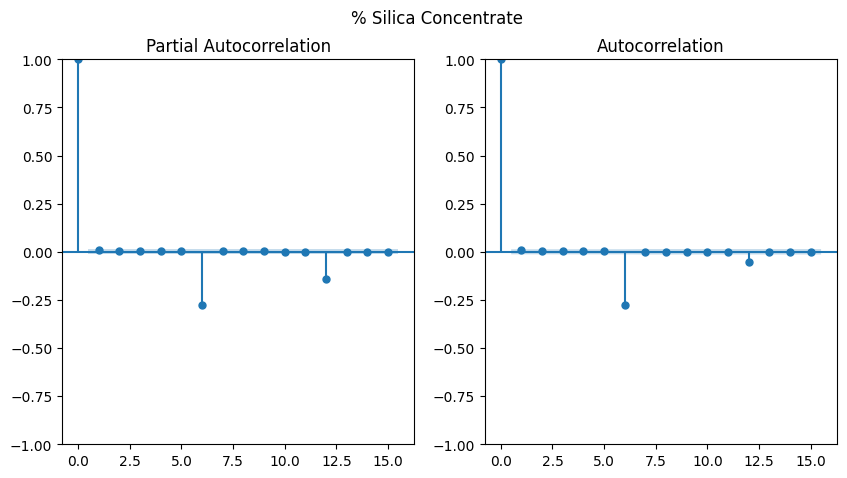

,% Silica Concentrate
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0


In [23]:
y = pd.DataFrame([])
for i in Y.columns :
    y[i] = Y[i] - Y[i].shift(1)
y.dropna(inplace=True)

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
for i in Y.columns :
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    fig.suptitle(i)
    plot_pacf(y[i], lags=15, ax=ax1)
    plot_acf(y[i], lags=15, ax=ax2)
    plt.show()
    
y.head()

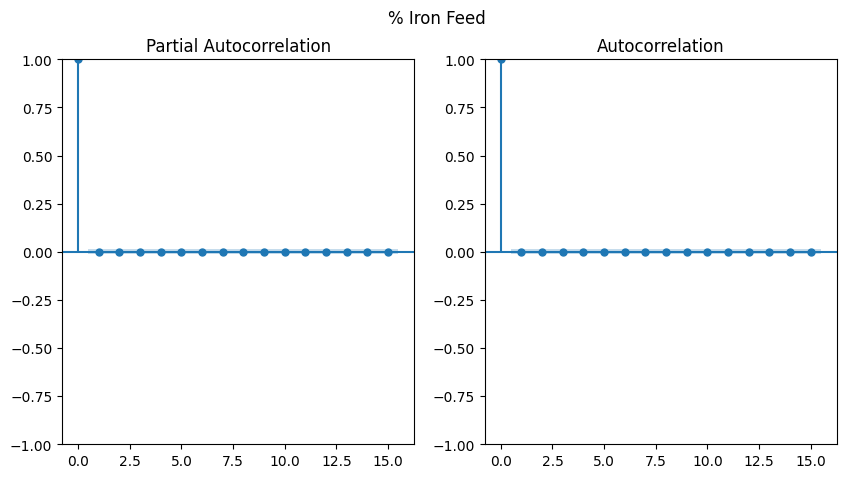

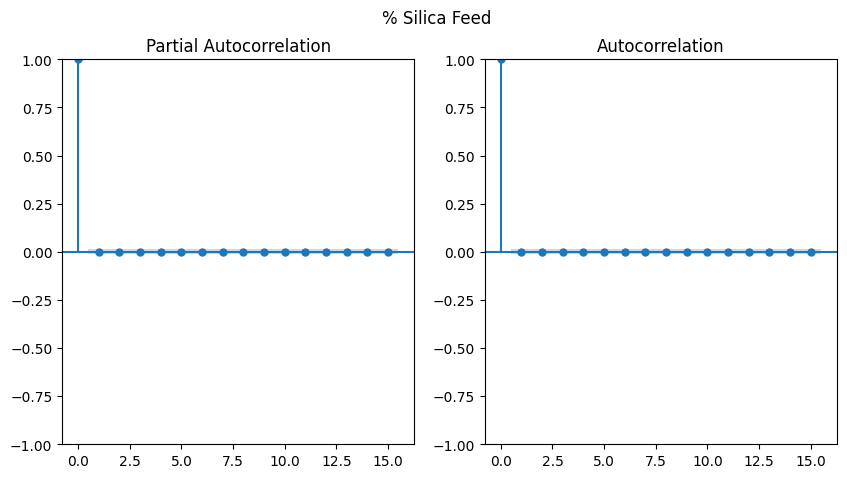

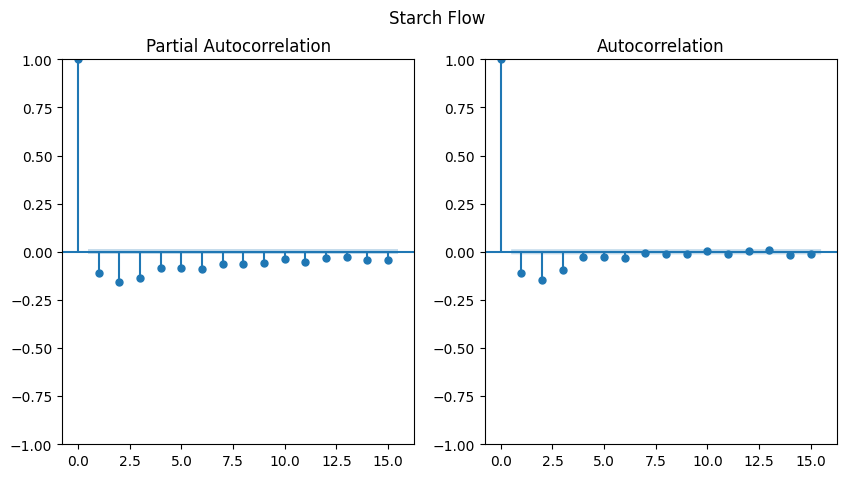

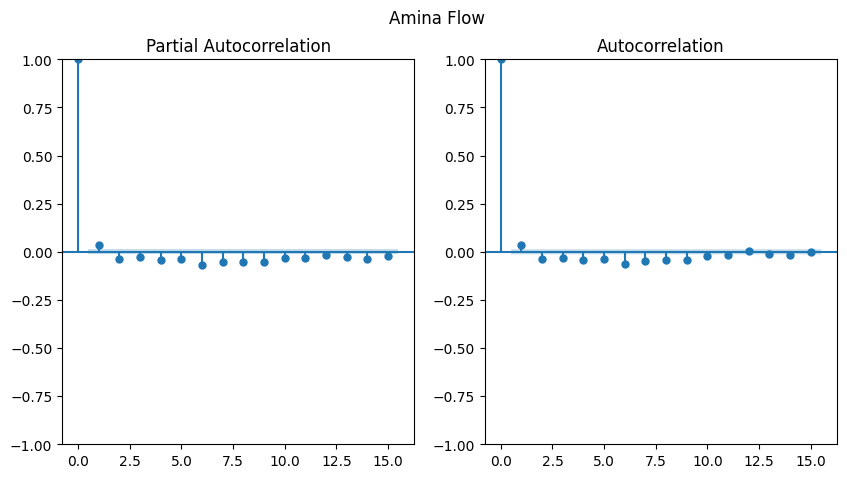

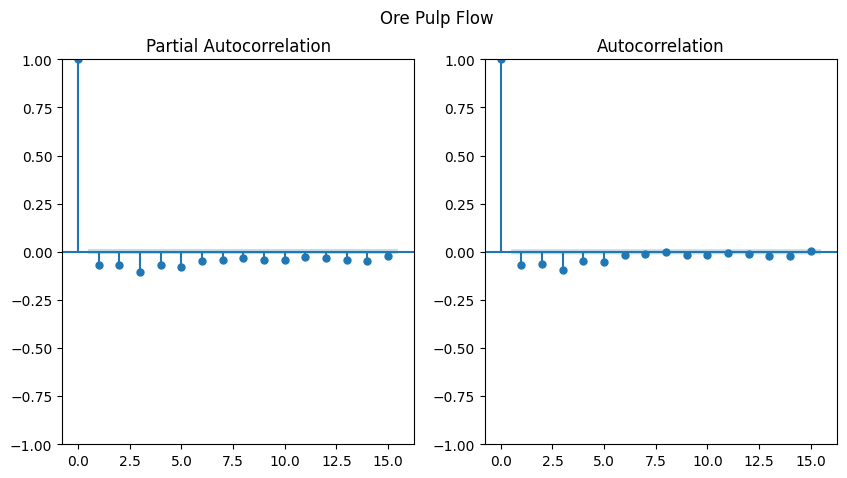

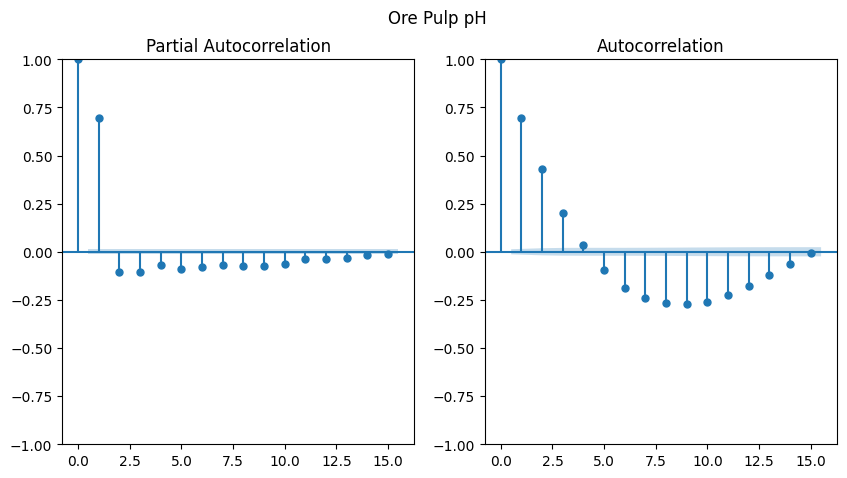

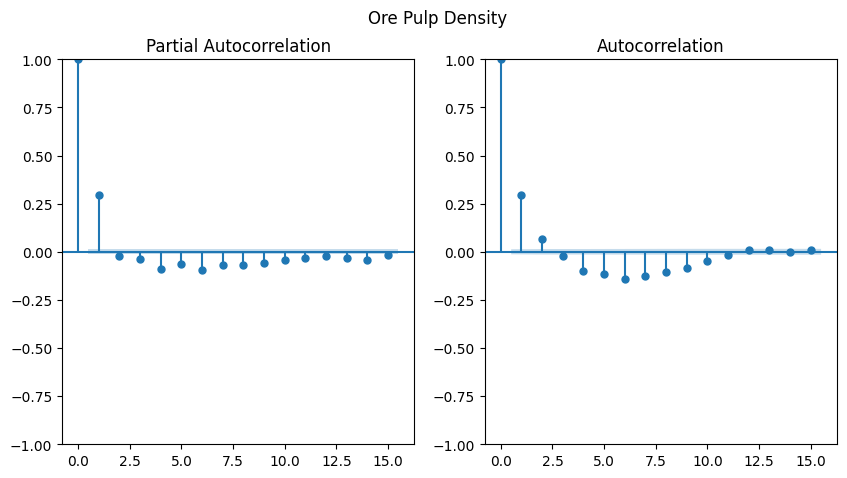

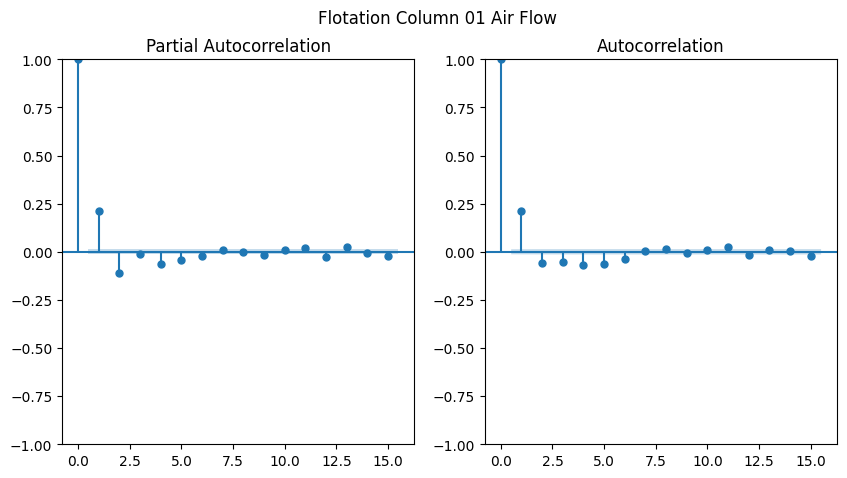

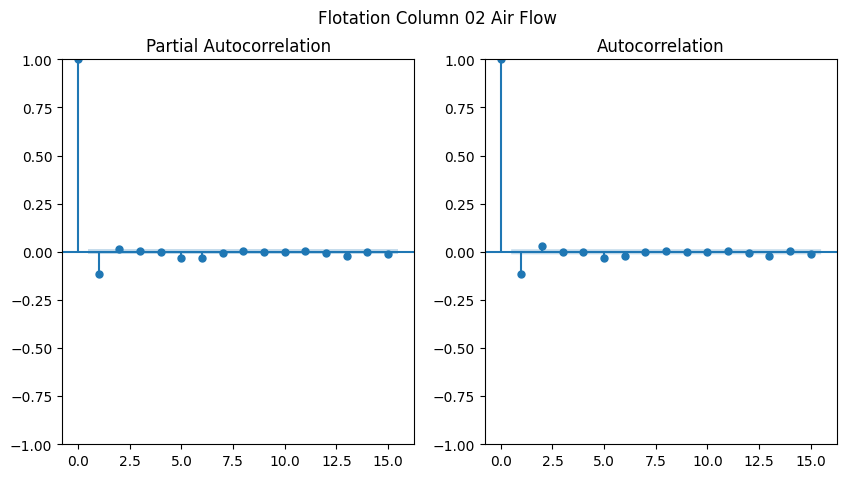

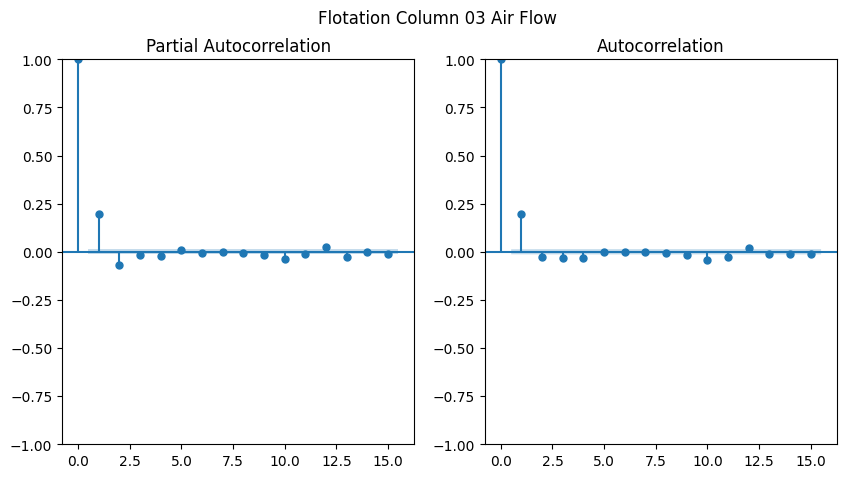

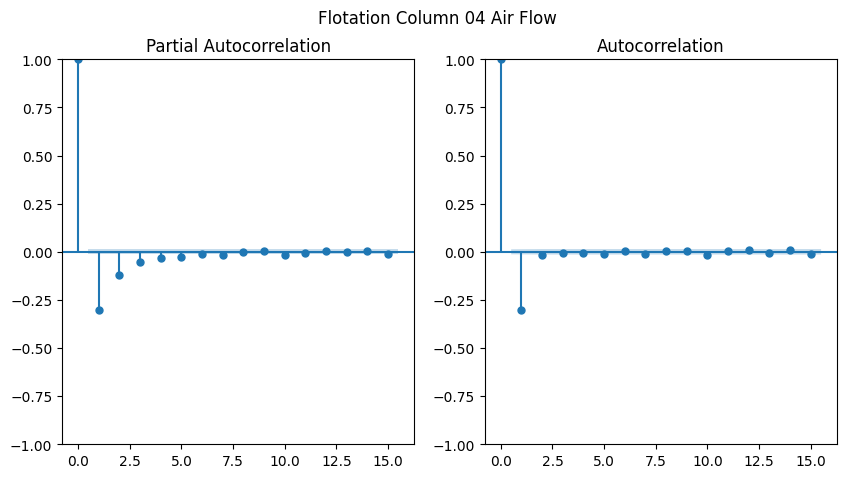

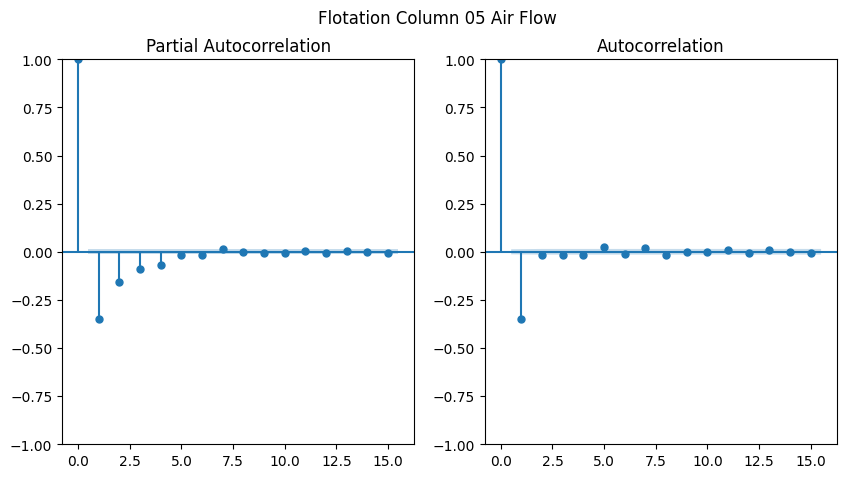

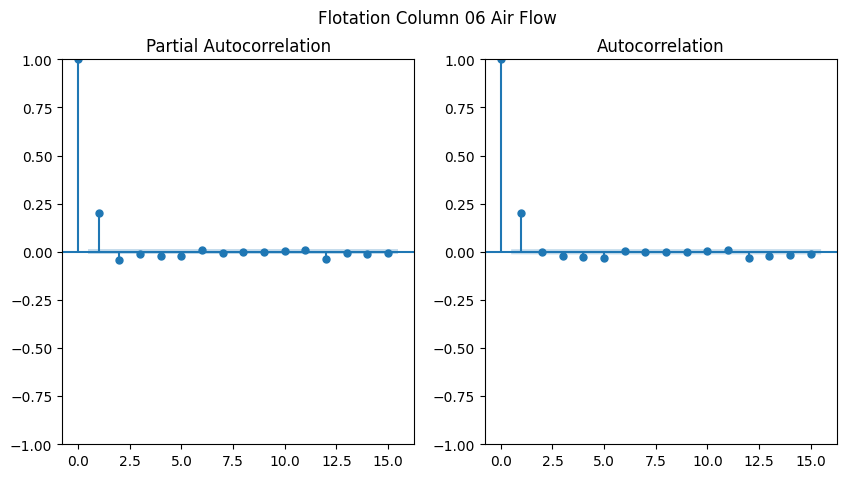

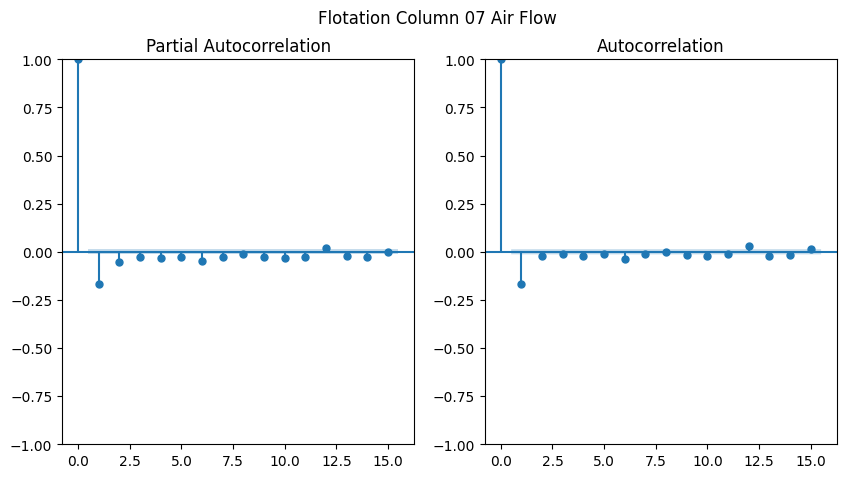

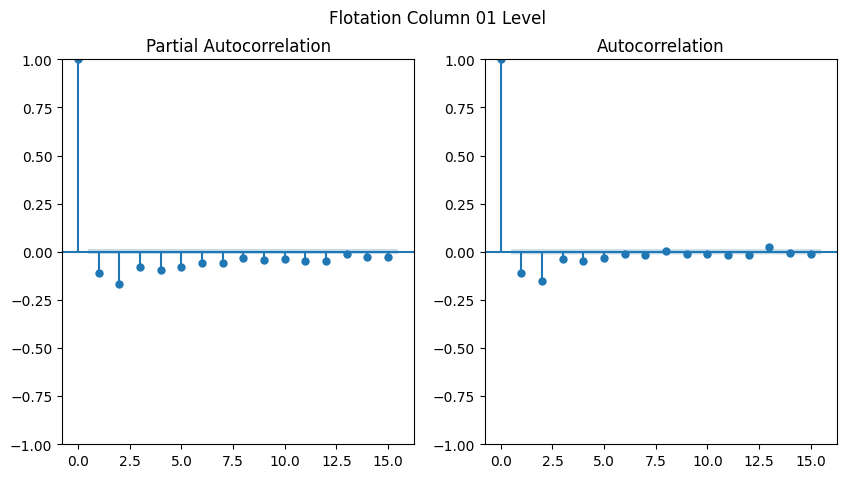

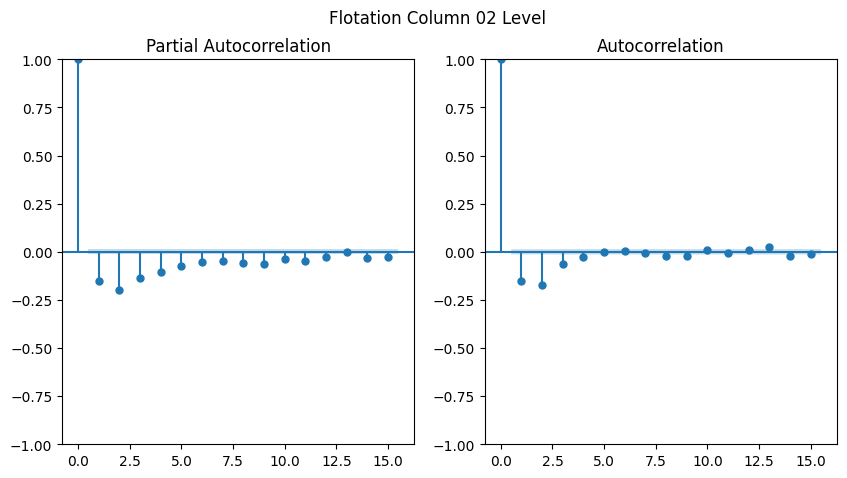

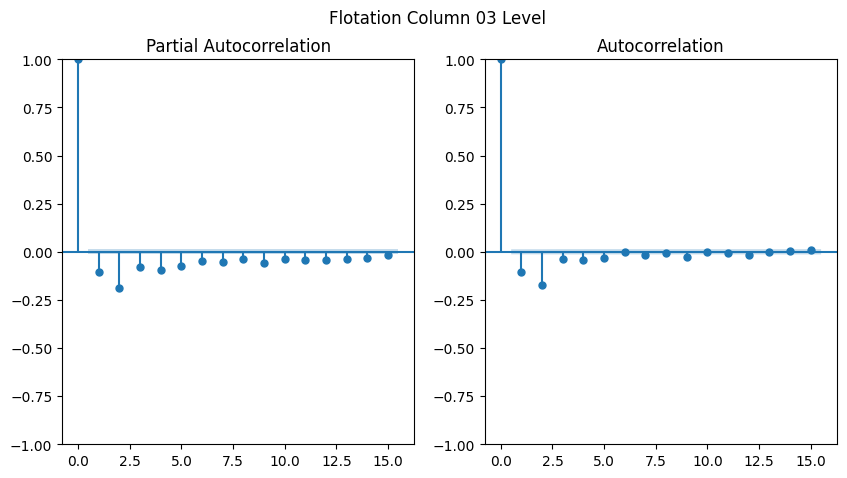

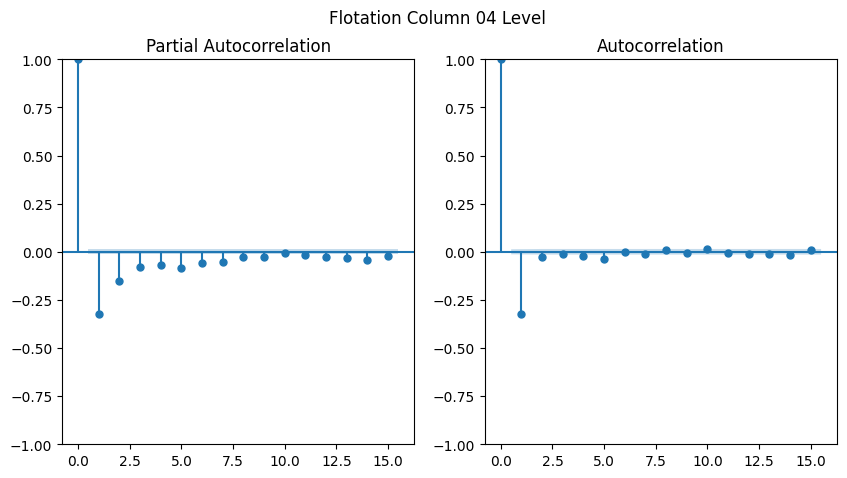

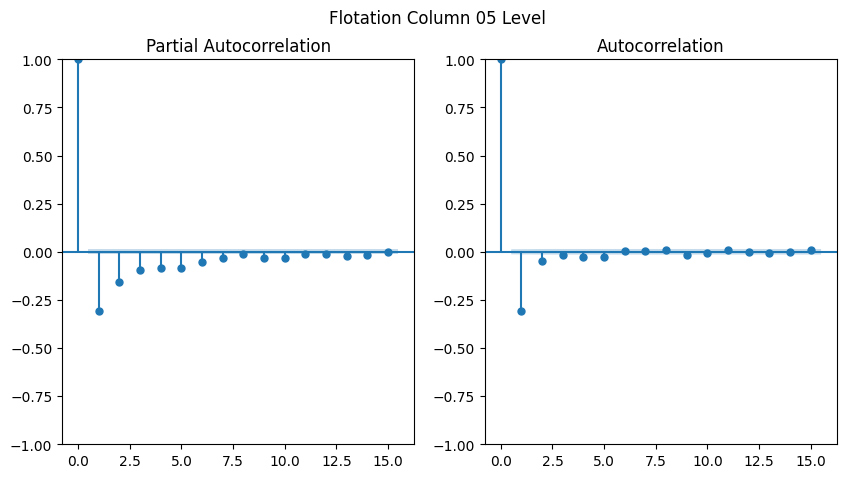

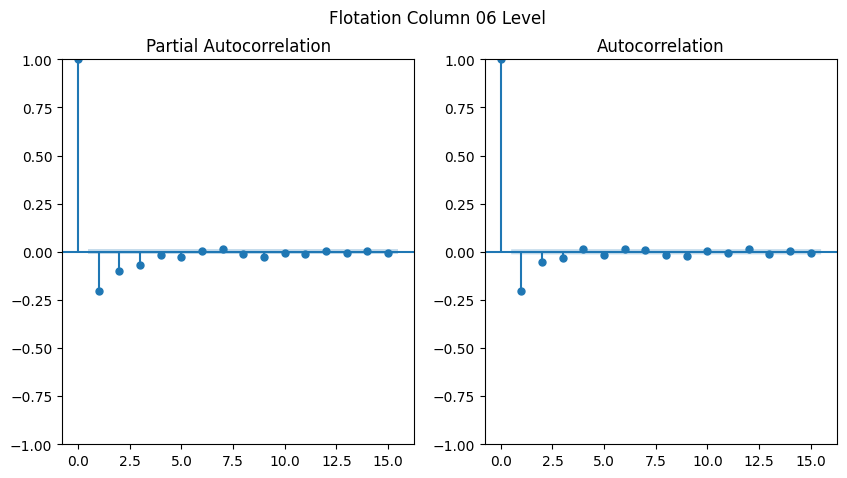

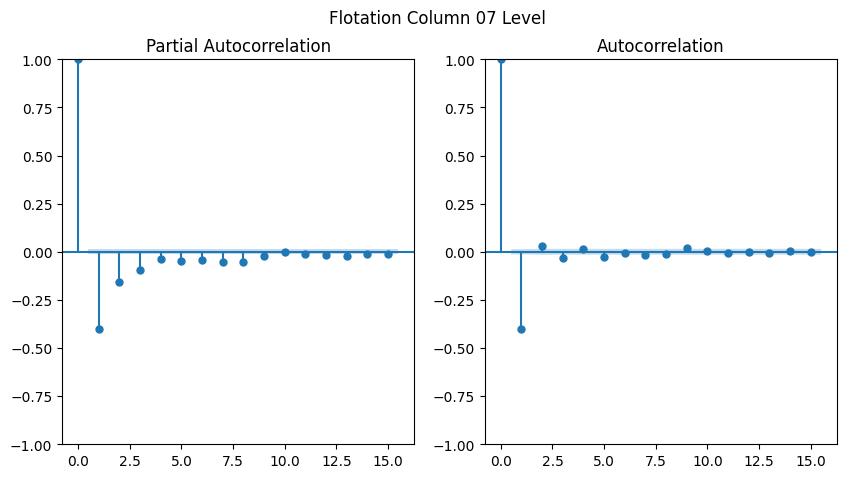

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level
1,0.0,0.0,0.054427,-0.008662,-0.073264,0.029251,0.070884,0.019129,-0.049533,0.003656,...,0.0,-0.025966,-0.024010,-0.014158,-0.009985,-0.002642,-0.076297,-0.040290,0.049052,0.027898
2,0.0,0.0,0.213566,0.075829,0.009176,0.121664,0.061058,0.015745,0.027240,0.010158,...,0.0,0.037430,0.028819,0.025136,0.010448,-0.013418,0.052947,0.027875,-0.025107,0.020328
3,0.0,0.0,-0.171611,-0.015522,-0.478608,0.112206,0.096267,-0.007456,0.017130,-0.000271,...,0.0,-0.063311,-0.008391,-0.025473,-0.016574,0.023182,-0.007400,0.011206,-0.013642,0.007945
4,0.0,0.0,-0.209238,-0.126147,0.613830,-0.032549,-0.025016,-0.000658,-0.041467,-0.009970,...,0.0,0.037384,0.032909,0.041090,0.014998,-0.007971,0.062474,0.041625,-0.048134,-0.157569
5,0.0,0.0,-0.047063,-0.105759,-0.240232,0.001085,-0.013727,-0.008822,0.042363,0.002185,...,0.0,0.050173,-0.020794,-0.017679,-0.005583,-0.005001,-0.063544,-0.054015,0.042148,0.154662


In [24]:
x = pd.DataFrame([])
for i in X.columns :
    x[i] = X[i] - X[i].shift(1)
x.dropna(inplace=True)

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
for i in X.columns :
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    fig.suptitle(i)
    plot_pacf(x[i], lags=15, ax=ax1)
    plot_acf(x[i], lags=15, ax=ax2)
    plt.show()
    
x.head()

In [52]:
model = sm.tsa.VAR(data)
result = sm.tsa.VAR.select_order(model)
result.summary()

,AIC,BIC,FPE,HQIC
0,111.7,111.8,3.406e+48,111.8
1,54.95,55.13,7.311e+23,55.01
2,53.01,53.37,1.054e+23,53.13
3,52.78,53.32*,8.349e+22,52.95
4,52.69,53.40,7.624e+22,52.92
5,52.64,53.53,7.262e+22,52.93
6,52.60,53.67,6.993e+22,52.95
7,52.51,53.76,6.394e+22,52.92*
8,52.50,53.93,6.342e+22,52.97
9,52.50,54.10,6.293e+22,53.02


# Predicting

In [41]:
data = pd.read_csv(path+'230609.csv', index_col=0)
data = data.drop(['time_idx', 'hour','% Iron Concentrate', 'time_range', 'dawn', 'day', 'night'],axis=1)
data

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Silica Concentrate
0,56.90,13.27,2188.172667,496.410433,400.979500,9.656423,1.748558,249.375633,250.348200,249.964633,...,250.029067,250.081467,699.654500,700.733367,700.101233,452.563067,451.789533,449.743700,449.483467,1.43
1,56.90,13.27,2246.475667,495.634233,400.291533,9.667804,1.753257,249.868133,249.040433,250.053367,...,249.317800,249.485167,698.061567,699.669467,699.742700,446.351400,448.587867,453.563433,451.585900,1.43
2,56.90,13.27,2475.248333,502.428933,400.377700,9.715140,1.757305,250.273500,249.759633,250.299933,...,250.343100,250.200900,700.889667,700.782800,697.921467,450.662033,450.802967,451.608367,453.117867,1.43
3,56.90,13.27,2291.417667,501.038067,395.883467,9.758797,1.763687,250.081533,250.211900,250.293367,...,248.608867,249.992500,698.023633,699.016767,701.067967,450.059533,451.693433,450.546067,453.716600,1.43
4,56.90,13.27,2067.281000,489.734600,401.647467,9.746133,1.762028,250.064600,249.117100,250.051367,...,249.632900,250.809800,702.646667,700.614833,699.986133,455.145800,455.001233,446.797833,441.841933,1.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21883,49.75,23.20,4067.137000,454.760300,380.728578,9.670436,1.675748,299.134467,299.967633,299.752200,...,347.561667,329.237600,397.769600,506.467500,863.000200,398.004533,511.730433,400.379267,398.043367,1.71
21884,49.75,23.20,4627.553667,452.789033,380.941306,9.684356,1.668100,299.398267,300.473267,299.590367,...,349.703733,317.866417,398.061067,499.167533,859.978667,400.230533,509.400967,400.798467,399.840200,1.71
21885,49.75,23.20,3541.358917,469.458333,380.028483,9.663314,1.664976,300.264367,300.287800,299.860400,...,348.580700,317.615483,400.882400,497.579433,877.082975,399.256200,487.546567,402.115133,399.659100,1.71
21886,49.75,23.20,3349.900667,463.325200,381.683533,9.626011,1.657615,299.975333,300.737933,300.122467,...,351.001533,308.140417,402.395967,493.738267,883.201692,408.094767,508.029500,403.606767,404.874067,1.71


# Size 21888

In [43]:
train = data[:16416]
test = data[16416:]

In [45]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures,SmartCorrelatedSelection


pip = Pipeline([('constant', DropConstantFeatures(tol=0.90)), ('duplicate', DropDuplicateFeatures()), ('correlated', SmartCorrelatedSelection(threshold=0.8))])
train_pro = pip.fit_transform(train.drop(['% Silica Concentrate'], axis=1))
train_pro['% Silica Concentrate'] = train['% Silica Concentrate']

In [46]:
columns = train_pro.columns
test_pro = test[columns]
test_pro['% Silica Concentrate'] = test['% Silica Concentrate']

In [58]:
error =[]
VAR_model = sm.tsa.VAR(train_pro)
results = VAR_model.fit(3)
forecast = results.forecast(train_pro.values[-3:], 5472)
    
a= 0
for j in range(5472) :
    a += (abs(forecast[j][-1] - test_pro['% Silica Concentrate'].iloc[j]))
    
error.append(a/5472)
    
error

[0.9409041305343662]

In [59]:
sum(error)/len(error)

0.9409041305343662

# Size 10944

In [78]:
batch = []

for i in range(2) :
    batch.append(data[(data.index < 10944*(i+1) ) & (data.index >= 10944*i)])

In [79]:
train = []
test = []

for i in range(2) :
    train.append(batch[i][:8208])
    test.append(batch[i][8208:])

In [80]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures,SmartCorrelatedSelection

train_pro=[]

for i in range(2) :
    pip = Pipeline([('constant', DropConstantFeatures(tol=0.90)), ('duplicate', DropDuplicateFeatures()), ('correlated', SmartCorrelatedSelection(threshold=0.8))])
    a = pip.fit_transform(train[i].drop(['% Silica Concentrate'], axis=1))
    train_pro.append(a)
    train_pro[i]['% Silica Concentrate'] = train[i]['% Silica Concentrate']

In [81]:
test_pro = [0 for i in range(2)]

for i in range(2) :
    columns = train_pro[i].columns
    test_pro[i] = test[i][columns]
    test_pro[i]['% Silica Concentrate'] = test[i]['% Silica Concentrate']
    

In [93]:
error = []

for i in range(2) :
    VAR_model = sm.tsa.VAR(train_pro[i])
    results = VAR_model.fit(maxlags=15, ic='bic')
    forecast = results.forecast(train_pro[i].values[-15:], 2736)
    
    a= 0
    for j in range(2736) :
        a += (abs(forecast[j][-1] - test_pro[i]['% Silica Concentrate'].iloc[j]))
    error.append(a/2736)
    
error

/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[0.7911833225840239, 0.960429237795553]

In [94]:
sum(error)/len(error)

0.8758062801897885

# Size 5472

In [95]:
batch = []

for i in range(4) :
    batch.append(data[(data.index < 5472*(i+1) ) & (data.index >= 5472*i)])

In [97]:
train = []
test = []

for i in range(4) :
    train.append(batch[i][:4104])
    test.append(batch[i][4104:])

In [98]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures,SmartCorrelatedSelection

train_pro=[]

for i in range(4) :
    pip = Pipeline([('constant', DropConstantFeatures(tol=0.90)), ('duplicate', DropDuplicateFeatures()), ('correlated', SmartCorrelatedSelection(threshold=0.8))])
    a = pip.fit_transform(train[i].drop(['% Silica Concentrate'], axis=1))
    train_pro.append(a)
    train_pro[i]['% Silica Concentrate'] = train[i]['% Silica Concentrate']

In [99]:
test_pro = [0 for i in range(4)]

for i in range(4) :
    columns = train_pro[i].columns
    test_pro[i] = test[i][columns]
    test_pro[i]['% Silica Concentrate'] = test[i]['% Silica Concentrate']
    

In [100]:
error = []

for i in range(4) :
    VAR_model = sm.tsa.VAR(train_pro[i])
    results = VAR_model.fit(maxlags=15, ic='bic')
    forecast = results.forecast(train_pro[i].values[-15:], 1368)
    
    a= 0
    for j in range(1368) :
        a += (abs(forecast[j][-1] - test_pro[i]['% Silica Concentrate'].iloc[j]))
    error.append(a/1368)
    
error

/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[1.0999516337700606,
 0.6818422900073745,
 0.7541441855692437,
 0.9412641102454214]

In [101]:
sum(error)/len(error)

0.869300554898025

# Size 2736

In [103]:
batch = []

for i in range(8) :
    batch.append(data[(data.index < 2736*(i+1) ) & (data.index >= 2736*i)])

In [104]:
train = []
test = []

for i in range(8) :
    train.append(batch[i][:2052])
    test.append(batch[i][2052:])

In [106]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures,SmartCorrelatedSelection

train_pro=[]

for i in range(8) :
    pip = Pipeline([('constant', DropConstantFeatures(tol=0.90)), ('duplicate', DropDuplicateFeatures()), ('correlated', SmartCorrelatedSelection(threshold=0.8))])
    a = pip.fit_transform(train[i].drop(['% Silica Concentrate'], axis=1))
    train_pro.append(a)
    train_pro[i]['% Silica Concentrate'] = train[i]['% Silica Concentrate']

In [107]:
test_pro = [0 for i in range(8)]

for i in range(8) :
    columns = train_pro[i].columns
    test_pro[i] = test[i][columns]
    test_pro[i]['% Silica Concentrate'] = test[i]['% Silica Concentrate']
    

In [108]:
error = []

for i in range(8) :
    VAR_model = sm.tsa.VAR(train_pro[i])
    results = VAR_model.fit(maxlags=15, ic='bic')
    forecast = results.forecast(train_pro[i].values[-15:], 684)
    
    a= 0
    for j in range(684) :
        a += (abs(forecast[j][-1] - test_pro[i]['% Silica Concentrate'].iloc[j]))
    error.append(a/684)
    
error

/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupp

[1.1395292145068046,
 1.0460501124330905,
 0.5699639142744743,
 0.794259520709578,
 0.8159899315369418,
 0.8224059359982399,
 1.157373129219075,
 0.7043900973255752]

In [109]:
sum(error)/len(error)

0.8812452320004724

# Size 1368

In [111]:
batch = []

for i in range(16) :
    batch.append(data[(data.index < 1368*(i+1) ) & (data.index >= 1368*i)])

In [112]:
train = []
test = []

for i in range(16) :
    train.append(batch[i][:1026])
    test.append(batch[i][1026:])

In [113]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures,SmartCorrelatedSelection

train_pro=[]

for i in range(16) :
    pip = Pipeline([('constant', DropConstantFeatures(tol=0.90)), ('duplicate', DropDuplicateFeatures()), ('correlated', SmartCorrelatedSelection(threshold=0.8))])
    a = pip.fit_transform(train[i].drop(['% Silica Concentrate'], axis=1))
    train_pro.append(a)
    train_pro[i]['% Silica Concentrate'] = train[i]['% Silica Concentrate']

In [114]:
test_pro = [0 for i in range(16)]

for i in range(16) :
    columns = train_pro[i].columns
    test_pro[i] = test[i][columns]
    test_pro[i]['% Silica Concentrate'] = test[i]['% Silica Concentrate']
    

In [115]:
error = []

for i in range(16) :
    VAR_model = sm.tsa.VAR(train_pro[i])
    results = VAR_model.fit(maxlags=15, ic='bic')
    forecast = results.forecast(train_pro[i].values[-15:], 342)
    
    a= 0
    for j in range(342) :
        a += (abs(forecast[j][-1] - test_pro[i]['% Silica Concentrate'].iloc[j]))
    error.append(a/342)
    
error

/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupp

[1.110333891813812,
 1.1149155836287232,
 0.8666211940867111,
 1.0329540583497816,
 0.7621632215371873,
 0.788205023747115,
 0.4769270365483167,
 0.9210286904209435,
 0.7000521525335974,
 0.854996450295103,
 0.5176216110067275,
 0.8286069951354421,
 1.2417179353055887,
 1.1204281336365647,
 1.4443822363692773,
 0.9585092105841627]

In [116]:
sum(error)/len(error)

0.9212164640624408

# Size684

In [151]:
batch = []

for i in range(32) :
    batch.append(data[(data.index < 684*(i+1) ) & (data.index >= 684*i)])

In [152]:
train = []
test = []

for i in range(32) :
    train.append(batch[i][:513])
    test.append(batch[i][513:])

In [153]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures,SmartCorrelatedSelection

train_pro=[]

for i in range(32) :
    pip = Pipeline([('constant', DropConstantFeatures(tol=0.90)), ('duplicate', DropDuplicateFeatures()), ('correlated', SmartCorrelatedSelection(threshold=0.8))])
    a = pip.fit_transform(train[i].drop(['% Silica Concentrate'], axis=1))
    train_pro.append(a)
    train_pro[i]['% Silica Concentrate'] = train[i]['% Silica Concentrate']

In [154]:
test_pro = [0 for i in range(32)]

for i in range(32) :
    columns = train_pro[i].columns
    test_pro[i] = test[i][columns]
    test_pro[i]['% Silica Concentrate'] = test[i]['% Silica Concentrate']
    

In [155]:
error = []

for i in range(32) :
    VAR_model = sm.tsa.VAR(train_pro[i])
    results = VAR_model.fit(1)
    forecast = results.forecast(train_pro[i].values[-1:], 171)
    
    a= 0
    for j in range(171) :
        a += (abs(forecast[j][-1] - test_pro[i]['% Silica Concentrate'].iloc[j]))
    error.append(a/171)
    
error

/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/slcf/anaconda3/envs/jwj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupp

[0.7766562492413861,
 1.815419724129305,
 1.1930128991500142,
 0.6047228669813501,
 0.6716313859620757,
 1.0292725335386925,
 0.776115319278542,
 1.272900575713384,
 1.0148927224588113,
 0.5339311739144113,
 0.5852525493867975,
 0.9069444661347114,
 0.45664421228818103,
 0.3944931029870903,
 1.0531310218089849,
 0.9814343996373365,
 0.6220854454830478,
 0.648457394558074,
 0.6367908205413473,
 1.2814075699354888,
 0.4046823210224,
 0.5407479058704249,
 0.8677838985568291,
 0.20219849687933536,
 1.2530853742917347,
 1.032395546329054,
 0.7763785656771237,
 1.3886155392336432,
 0.7160460878580949,
 0.8097819510509774,
 0.8969756792797855,
 0.5701618184083505]

In [156]:
sum(error)/len(error)

0.8348140505495871

# Size342

In [226]:
batc = []

for i in range(64) :
    batc.append(data[(data.index <= 342*(i+1) ) & (data.index >= 342*i)])

In [227]:
batch = [0 for i in range(64)]

for i in range(64) :
    X = batc[i].drop(['% Silica Concentrate'], axis = 1)
    Y = batc[i][['% Silica Concentrate']]
    X_2 = X.drop(X.index[-1:], axis=0)
    X_3 = X_2.reset_index(drop=True)
    Y_2 = Y.drop(Y.index[:1], axis=0)
    Y_3 = Y_2.reset_index(drop=True)
    batch[i] = pd.concat([X_3,Y_3], axis=1 )

In [240]:
train = []
test = []

for i in range(64) :
    train.append(batch[i][:256])
    test.append(batch[i][256:])

In [241]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures,SmartCorrelatedSelection

train_pro=[]

for i in range(64) :
    pip = Pipeline([('constant', DropConstantFeatures(tol=0.90)), ('duplicate', DropDuplicateFeatures()), ('correlated', SmartCorrelatedSelection(threshold=0.8))])
    a = pip.fit_transform(train[i].drop(['% Silica Concentrate'], axis=1))
    train_pro.append(a)
    train_pro[i]['% Silica Concentrate'] = train[i]['% Silica Concentrate']

In [242]:
test_pro = [0 for i in range(64)]

for i in range(64) :
    columns = train_pro[i].columns
    test_pro[i] = test[i][columns]
    test_pro[i]['% Silica Concentrate'] = test[i]['% Silica Concentrate']
    

In [243]:
test_pro

[     % Iron Feed  Starch Flow  Ore Pulp pH  Ore Pulp Density  \
 256        56.77  1132.178967     9.485323          1.738432   
 257        56.77   855.183567     9.546877          1.682774   
 258        56.77   823.188400     9.553240          1.640638   
 259        56.77   882.821467     9.523300          1.591633   
 260        56.77   935.561246     9.511730          1.540429   
 ..           ...          ...          ...               ...   
 337        55.60  2017.353333     9.956245          1.677129   
 338        55.60  2069.572000     9.892667          1.694239   
 339        55.60  2179.588333     9.785402          1.708331   
 340        55.60  1918.545333     9.730219          1.720968   
 341        55.60  1723.780667     9.723982          1.738380   
 
      Flotation Column 02 Air Flow  Flotation Column 04 Air Flow  \
 256                    249.643033                    296.148141   
 257                    248.958400                    296.145194   
 258          

In [244]:
error = []

a= 0
for i in range(64) :
    VAR_model = sm.tsa.VAR(train_pro[i])
    results = VAR_model.fit(1)
    forecast = results.forecast(train_pro[i].values[-1:], 85)
    
    a= 0
    for j in range(85) :
        a += (abs(forecast[j][-1] - test_pro[i]['% Silica Concentrate'].iloc[j]))
    error.append(a/85)
    
error

[0.5255254565582425,
 0.9448884963856733,
 0.7596205164267475,
 0.4621772262425305,
 0.669597291998493,
 2.2829951853894284,
 1.2661887069421423,
 0.861297067312325,
 0.4372288606713087,
 0.6416274015649818,
 1.180411547867481,
 1.161089422516792,
 1.0444927857668231,
 0.7186464141279796,
 1.0438001738443599,
 1.8053341362809132,
 0.8056762132795108,
 0.7463088229013721,
 0.46410823878339774,
 0.28364623238700043,
 0.17875344368543278,
 0.28555379227583366,
 0.38270548347200645,
 0.758192246044631,
 0.20871491146600876,
 0.3366289051334631,
 1.2079779557862091,
 0.20091011442064083,
 0.5139466835229161,
 0.8102073866727727,
 0.7293873937211562,
 1.4137995919807511,
 1.1967138759956963,
 0.4554135960572897,
 0.8430363773623433,
 0.3517670660661016,
 1.0561620635749798,
 0.5803022367930939,
 0.2874269948610913,
 0.7239578434322282,
 0.24872662188143183,
 2.4839972681721685,
 0.4396888784747784,
 0.833067963454593,
 0.7828018899632845,
 1.0457217549753401,
 1.6510237922191997,
 0.02263852

In [245]:
sum(error)/len(error)

0.8646153520496628